<a href="https://colab.research.google.com/github/heber-augusto/datascience-colab-templates/blob/master/template_acessing_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading data from url

In [3]:
import pandas as pd
url="https://introtomlsampledata.blob.core.windows.net/data/nyc-taxi/nyc-taxi-sample-data.csv"
nyc_taxi_dataframe = pd.read_csv(url)
nyc_taxi_dataframe

,vendorID,passengerCount,tripDistance,hour_of_day,day_of_week,day_of_month,month_num,normalizeHolidayName,isPaidTimeOff,snowDepth,precipTime,precipDepth,temperature,totalAmount
0,1,1,9.40,15,2,27,1,None,False,29.058824,24.0,3.0,6.185714,44.30
1,2,5,14.75,13,4,15,1,None,False,0.000000,6.0,0.0,4.571930,44.80
2,2,1,3.35,23,4,8,1,None,False,0.000000,1.0,0.0,4.384091,18.96
3,2,1,3.33,18,2,27,1,None,False,29.058824,24.0,3.0,6.185714,16.30
4,2,1,0.47,17,6,3,1,None,False,0.000000,1.0,0.0,3.846429,5.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11729,2,1,7.47,13,2,22,6,None,False,0.000000,1.0,0.0,25.704425,35.81
11730,2,1,3.76,0,3,16,6,None,False,0.000000,24.0,51.0,21.695868,16.30
11731,2,1,3.45,14,5,4,6,None,False,0.000000,24.0,41.0,21.990441,14.30
11732,1,1,20.20,1,6,19,6,None,False,0.000000,1.0,0.0,23.116071,68.15


# Reading data from json returned from REST API

Documentation from the REST api used here as an example can be find at the url
https://api.telemetria.hitecnologia.com.br/rest/docs/

In [9]:
import pandas as pd
import requests
import base64
import json
from getpass import getpass
from datetime import datetime, timedelta

# get user and password without showing
base  = "https://api.telemetria.hitecnologia.com.br/rest/v1/"
user = getpass('Enter the user name: ')
pwd  = getpass('Enter the secret value: ')

# encode password into base64
p=base64.b64encode(pwd.encode())
pwd=p.decode()
url='{}/auth/login/'.format(base)
headers={
    "Content-Type": "application/json", 
    "Accept": "application/json"
}
data={
    "email":"{}".format(user),
    "password":"{}".format(pwd)
}

# request token
response = requests.post(
    url=url,
    data=json.dumps(data), 
    headers=headers
)
result = json.loads(response.text)
access_token = result["token"]




Enter the user name: ··········
Enter the secret value: ··········


In [56]:
# get start and end datetime with ISO8601 format considering the last 24 hours
now_dt   = datetime.now()
end      = now_dt.isoformat()
start    = (now_dt - timedelta(days=1)).isoformat()

# format url to call rest api
data_ids = '128,129'
history_url = f'{base}data_history/?format=json&data_ids={data_ids}&start={start}&end={end}'

header={
    "Content-Type": "application/json", 
    "Accept": "application/json",
    "Authorization":"Bearer {0}".format(access_token),
}

# get temperature and humidity sensor values from last 24h
response = requests.get(history_url, headers=header)
df = pd.read_json(response.text)
# transform datetime column
df['date_time'] = pd.to_datetime(df['date_time'])


**Plot data returned from REST API grouping by id**

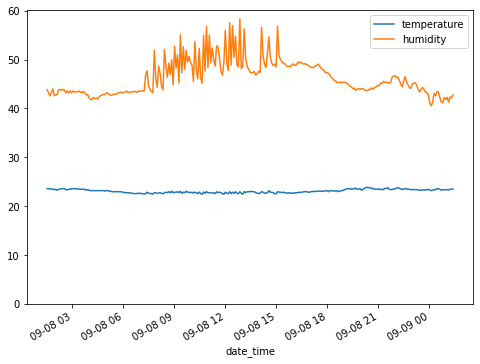

In [57]:
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(8,6))

# group by data_id 
# data_id 128 is temperature 
# data_id 129 is humidity
_ = df.groupby('data_id').plot(
    kind='line', 
    x = "date_time", 
    y = "value", 
    ax=ax)
ax.legend(['temperature', 'humidity'])
ax.set_ylim(ymin=0)
plt.show()





# Reading dataframe from files


*   excel;
*   csv.



In [91]:
import pandas as pd
import requests

filename = "example_file.xlsx"
ret = requests.get('https://raw.githubusercontent.com/heber-augusto/datascience-colab-templates/master/example_file.xlsx')

# save into current dir
f = open(filename, "wb")
f.write(ret.content)
f.close()

# load dataframe from excel file
df = pd.read_excel(filename)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S')

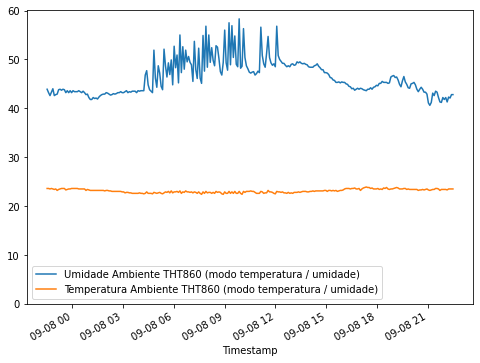

In [94]:
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(8,6))

_ = df.plot(
    kind='line', 
    x = "Timestamp", 
    ax=ax)
ax.set_ylim(ymin=0)
plt.show()



In [98]:
# load dataframe from excel file
df = pd.read_csv('https://raw.githubusercontent.com/heber-augusto/datascience-colab-templates/master/example_file.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S')


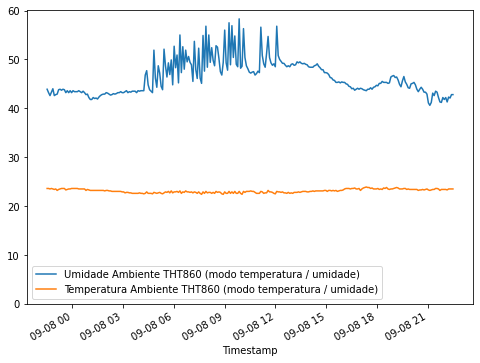

In [99]:
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(8,6))

_ = df.plot(
    kind='line', 
    x = "Timestamp", 
    ax=ax)
ax.set_ylim(ymin=0)
plt.show()

# Reading dataframe from oracle

Some installation into linux has to be done (https://cx-oracle.readthedocs.io/en/latest/user_guide/installation.html). There are some possible incompatibilities here. The code bellow did not run into Google Colab yet.

In [101]:
!pip install cx_Oracle



     |████████████████████████████████| 757kB 2.8MB/s 


In [ ]:
import cx_Oracle
import os
import datetime

#parameters to connect to Oracle database (there is a Docker file at the repo 
#to create a database instance)
ip = 'database'
port = 1521
SID = 'sid'
user = 'user'
password = 'password'

dsn_tns = cx_Oracle.makedsn(ip, port, SID)
#encoding and access parameters depends on database installation
connection = cx_Oracle.connect(user, 
                               password, 
                               dsn_tns, 
                               encoding = "UTF-8", 
                               nencoding = "UTF-8")


In [ ]:
def create_csvfile_from_query(
    connection, query, output_file): 
    """function to create csv file using query results:

    Args:
        connection (): connection to database.
        query (str): string containing query.
        output_file (str): output filename.
    Returns:
        Nothing
    """
    # limit the chuncksize to avoid Memory Error
    reader       = pd.read_sql(query, connection, chunksize=50000)

    #read chuncks until the end
    for chunk in reader:
        temp_regs = chunk
        # append or create file
        if os.path.isfile(output_file):
            temp_regs.to_csv(output_file,encoding='utf-8', mode='a', header=False)
        else:
            temp_regs.to_csv(output_file,encoding='utf-8')

# Reading dataframe from PostgreSQL

The code bellow was tested with a database but access information was removed.


In [103]:
!pip install psycopg2

In [105]:
import pandas as pd
from getpass import getpass
import psycopg2

your_pass = getpass(prompt='Password: ', stream=None)
conn_cred = {
    'host': your_host,
    'port': your_port,
    'dbname': your_databse,
    'user': your_user,
    'password': your_pass
}
conn = psycopg2.connect(**conn_cred)

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Password: ··········


In [106]:
def create_csvfile_from_query(
    connection, query, output_file): 
    """function to create csv file using query results:

    Args:
        connection (): connection to database.
        query (str): string containing query.
        output_file (str): output filename.
    Returns:
        Nothing
    """
    # limit the chuncksize to avoid Memory Error
    reader       = pd.read_sql(query, connection, chunksize=50000)

    #read chuncks until the end
    for chunk in reader:
        temp_regs = chunk
        # append or create file
        if os.path.isfile(output_file):
            temp_regs.to_csv(output_file,encoding='utf-8', mode='a', header=False)
        else:
            temp_regs.to_csv(output_file,encoding='utf-8')

In [108]:
create_csvfile_from_query(
    conn, 
    'select * from table1 LIMIT 100000',
    'output.csv')